In [141]:
#Bangs

#Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from sklearn.cluster import SpectralClustering
from sklearn.manifold import Isomap
from sklearn.manifold import SpectralEmbedding


In [142]:
# load the data
df = pd.read_csv('data/HR_data.csv')

cohort_to_session = {
    'D1_1': 'D11',  # winter
    'D1_2': 'D12',  # Fall
    'D1_3': 'D13',  # fall
    'D1_4': 'D13',  # fall
    'D1_5': 'D13',  # fall
    'D1_6': 'D13',  # fall
}

# Create a new column
df['Session'] = df['Cohort'].map(cohort_to_session)


cohort_to_timeCompleted = {
    'D1_1': 'Unknown',  # winter
    'D1_2': 'Unknown',  # Fall
    'D1_3': 'Morning',  # fall
    'D1_4': 'Evening',  # fall
    'D1_5': 'Morning',  # fall
    'D1_6': 'Evening',  # fall
}

df['TimeCompleted'] = df['Cohort'].map(cohort_to_timeCompleted)

In [143]:
# Checking for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)
print(missing_values)

Missing values in each column:
 Unnamed: 0       0
HR_TD_Mean       0
HR_TD_Median     0
HR_TD_std        0
HR_TD_Min        0
                ..
afraid           1
active           1
determined       2
Session          0
TimeCompleted    0
Length: 70, dtype: int64
Unnamed: 0       0
HR_TD_Mean       0
HR_TD_Median     0
HR_TD_std        0
HR_TD_Min        0
                ..
afraid           1
active           1
determined       2
Session          0
TimeCompleted    0
Length: 70, dtype: int64


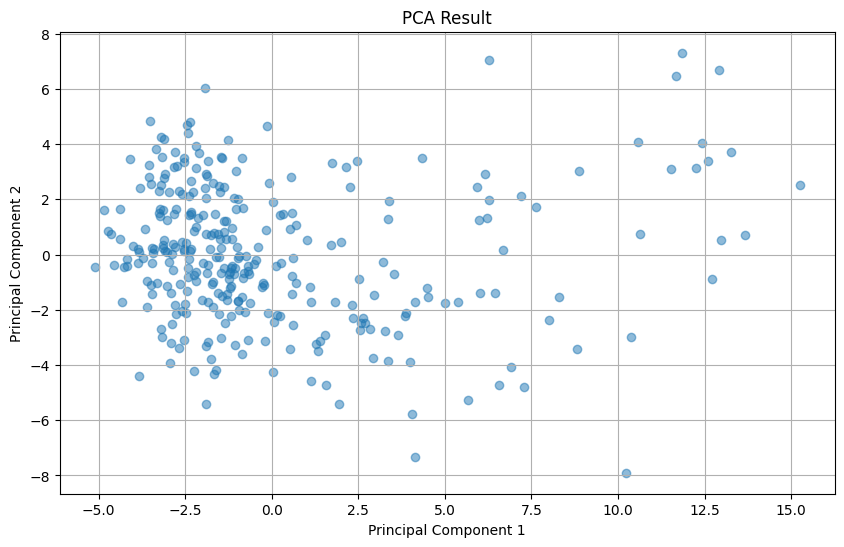

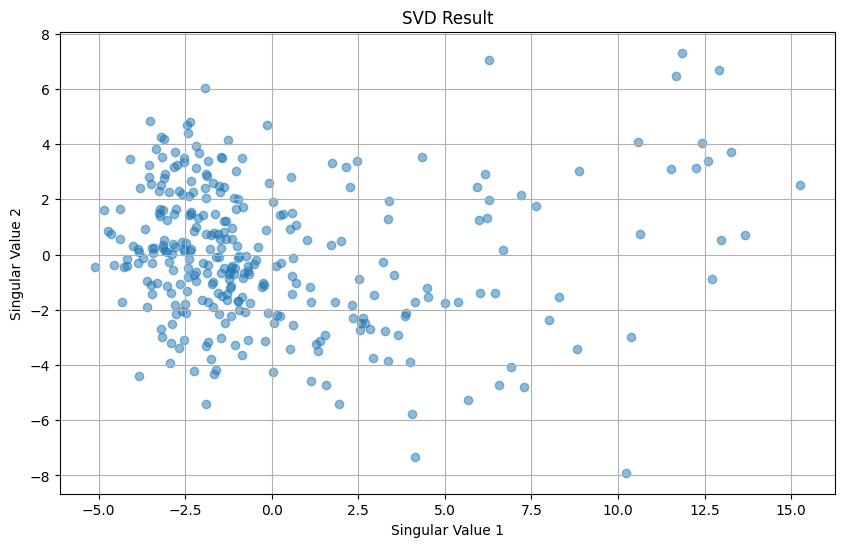

In [144]:
# Drop rows with missing values
df = df.dropna()

# Separate categorical and numerical data
numerical_data = df.select_dtypes(include=["number"])
categorical_columns = ["Round", "Phase", "Cohort", "Session", "TimeCompleted"]
categorical_data = df[categorical_columns]

# one hot encoding for categorical data
categorical_data = pd.get_dummies(categorical_data, columns = ["Round", "Phase", "Cohort", "Session", "TimeCompleted"],drop_first=True)

# Concatinate the numerical and categorical data
data = pd.concat([numerical_data, categorical_data], axis=1)

# Standardize the numerical data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Perform SVD
svd = TruncatedSVD(n_components=2)
svd_result = svd.fit_transform(data_scaled)
svd_df = pd.DataFrame(data=svd_result, columns=['SV1', 'SV2'])

# Plotting PCA results
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5)
plt.title('PCA Result')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

# Plotting SVD results
plt.figure(figsize=(10, 6))
plt.scatter(svd_df['SV1'], svd_df['SV2'], alpha=0.5)
plt.title('SVD Result')
plt.xlabel('Singular Value 1')
plt.ylabel('Singular Value 2')
plt.grid()




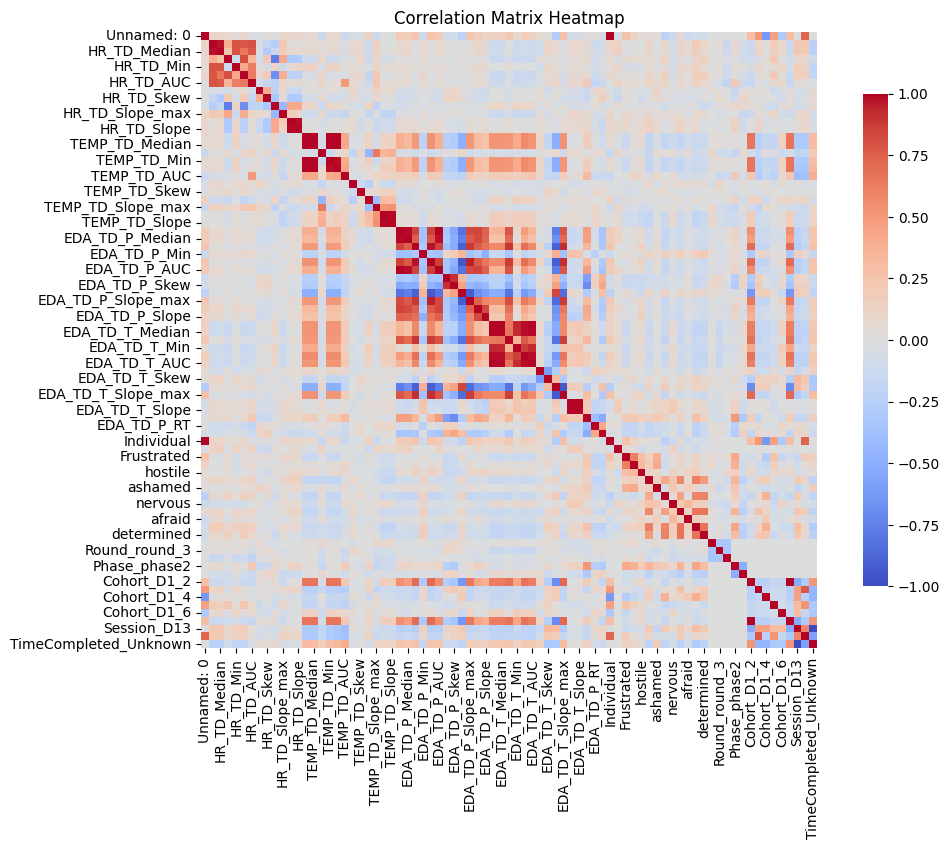

In [145]:
# Plot of heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=False, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix Heatmap')
plt.show()


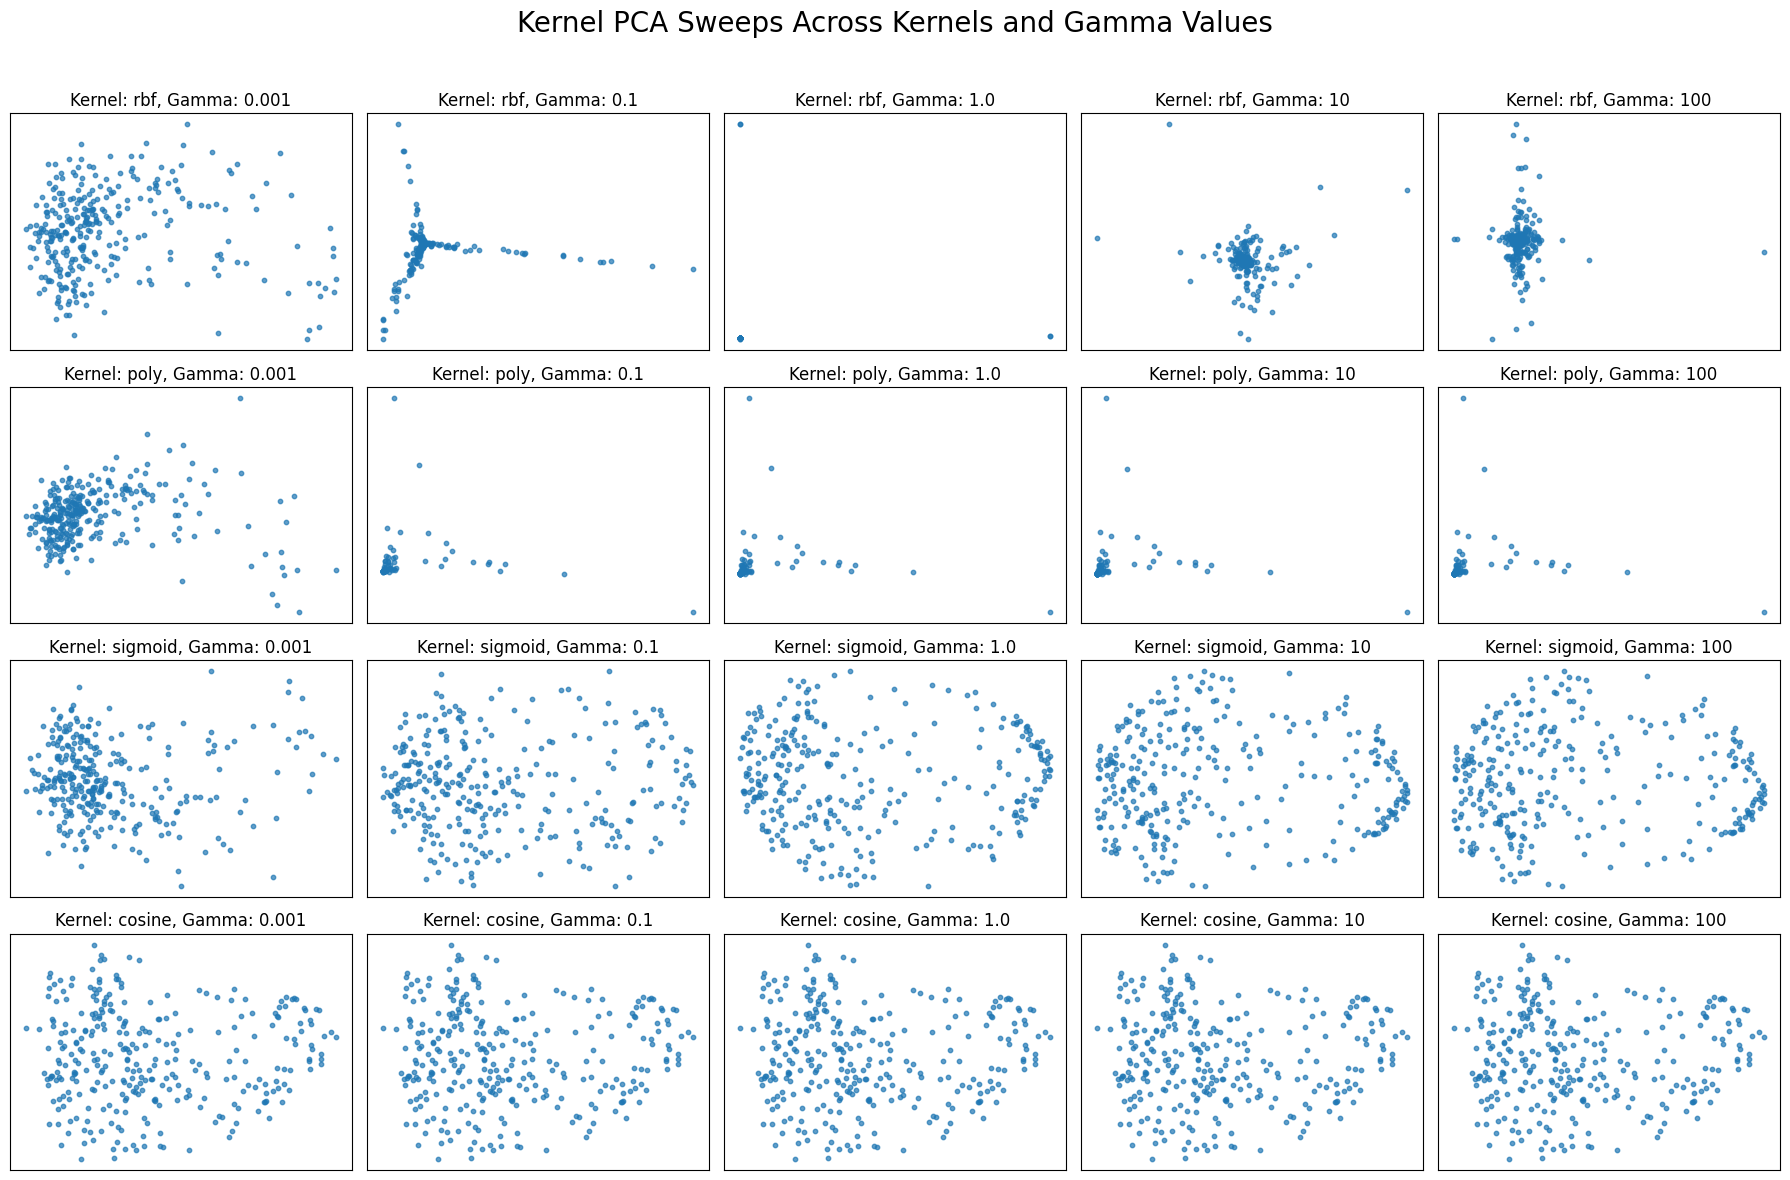

In [146]:
# Settings
kernels = ['rbf', 'poly', 'sigmoid', 'cosine']
gammas = [0.001, 0.1, 1.0, 10, 100]

# Plot
fig, axes = plt.subplots(len(kernels), len(gammas), figsize=(18, 12))
fig.suptitle('Kernel PCA Sweeps Across Kernels and Gamma Values', fontsize=20)

for i, kernel in enumerate(kernels):
    for j, gamma in enumerate(gammas):
        try:
            if kernel == 'cosine':
                # Cosine kernel doesn't use gamma
                kpca = KernelPCA(n_components=2, kernel=kernel)
            else:
                kpca = KernelPCA(n_components=2, kernel=kernel, gamma=gamma)

            components = kpca.fit_transform(data_scaled)
            ax = axes[i, j]
            ax.scatter(components[:, 0], components[:, 1], s=10, alpha=0.7)
            ax.set_title(f"Kernel: {kernel}, Gamma: {gamma}")
            ax.set_xticks([])
            ax.set_yticks([])
        except Exception as e:
            print(f"Kernel={kernel}, Gamma={gamma} failed: {e}")
            axes[i, j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


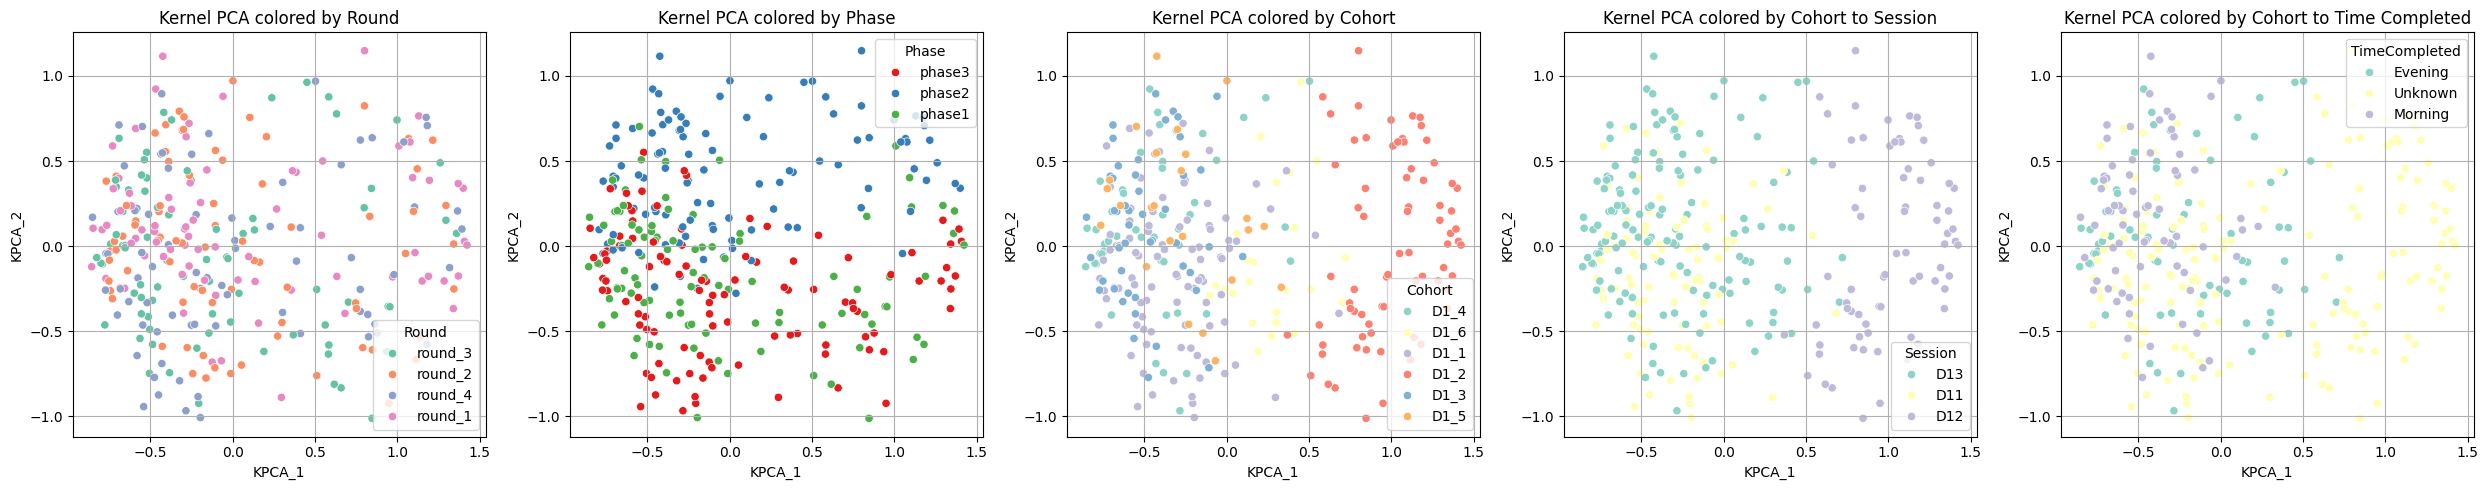

In [147]:
rounds = df["Round"]
phases = df["Phase"]
cohorts = df["Cohort"]
cohorts_session = df["Session"]
cohortts_timeCompleted = df["TimeCompleted"]

kpca = KernelPCA(n_components=2, kernel='sigmoid', gamma=0.1)
kpca_components = kpca.fit_transform(data_scaled)

kpca_df = pd.DataFrame(kpca_components, columns=["KPCA_1", "KPCA_2"])
kpca_df["Round"] = rounds.values
kpca_df["Phase"] = phases.values
kpca_df["Cohort"] = cohorts.values
kpca_df["Session"] = cohorts_session.values
kpca_df["TimeCompleted"] = cohortts_timeCompleted.values

fig, axes = plt.subplots(1, 5, figsize=(25, 5))

sns.scatterplot(data=kpca_df, x="KPCA_1", y="KPCA_2", hue="Round", ax=axes[0], palette="Set2")
axes[0].set_title("Kernel PCA colored by Round")
axes[0].grid(True)

sns.scatterplot(data=kpca_df, x="KPCA_1", y="KPCA_2", hue="Phase", ax=axes[1], palette="Set1")
axes[1].set_title("Kernel PCA colored by Phase")
axes[1].grid(True)

sns.scatterplot(data=kpca_df, x="KPCA_1", y="KPCA_2", hue="Cohort", ax=axes[2], palette="Set3")
axes[2].set_title("Kernel PCA colored by Cohort")
axes[2].grid(True)

sns.scatterplot(data=kpca_df, x="KPCA_1", y="KPCA_2", hue="Session", ax=axes[3], palette="Set3")
axes[3].set_title("Kernel PCA colored by Cohort to Session")
axes[3].grid(True)

sns.scatterplot(data=kpca_df, x="KPCA_1", y="KPCA_2", hue="TimeCompleted", ax=axes[4], palette="Set3")
axes[4].set_title("Kernel PCA colored by Cohort to Time Completed")
axes[4].grid(True)

plt.tight_layout()
plt.show()

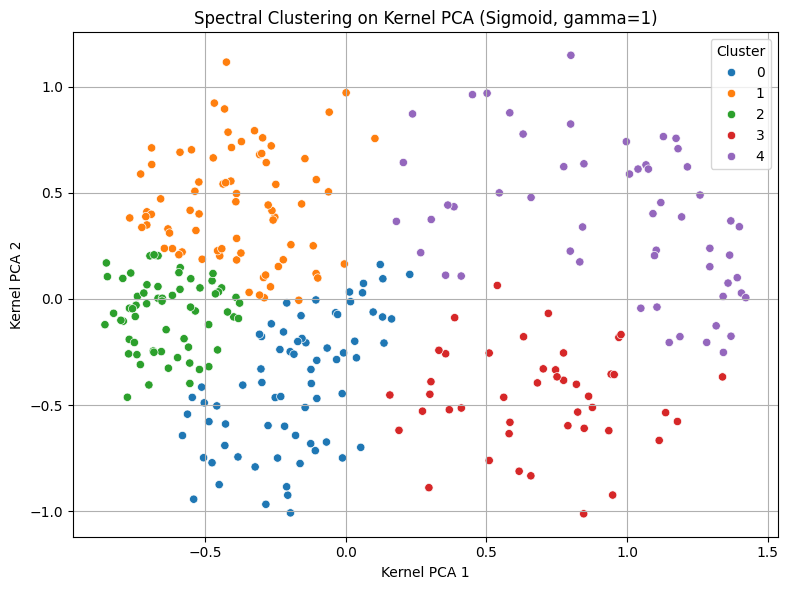

In [148]:
# Spectral Clustering
n_clusters = 5  # Number of clusters
spectral = SpectralClustering(n_clusters = n_clusters, affinity = 'nearest_neighbors', assign_labels = 'discretize',random_state = 42)
cluster_labels = spectral.fit_predict(kpca_components)

kpca_df["Cluster"] = cluster_labels

# plot the cluster results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=kpca_df, x="KPCA_1", y="KPCA_2", hue="Cluster", palette="tab10")
plt.title("Spectral Clustering on Kernel PCA (Sigmoid, gamma=1)")
plt.xlabel("Kernel PCA 1")
plt.ylabel("Kernel PCA 2")
plt.grid(True)
plt.tight_layout()
plt.show()

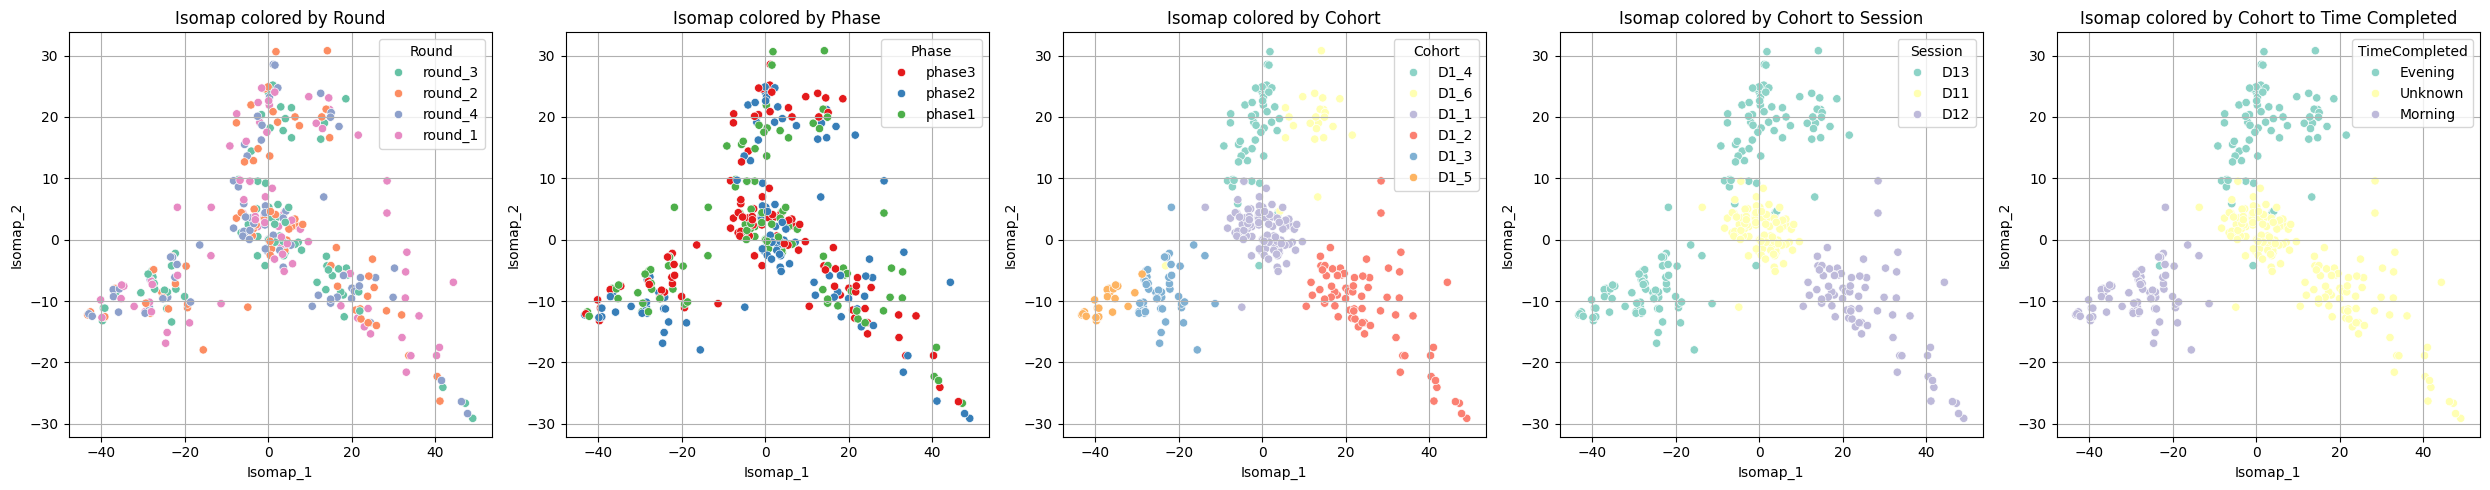

In [149]:
isomap = Isomap(n_neighbors=5, n_components=2)
isomap_components = isomap.fit_transform(data_scaled)

# Create a DataFrame for Isomap components
isomap_df = pd.DataFrame(isomap_components, columns=["Isomap_1", "Isomap_2"])
isomap_df["Round"] = rounds.values
isomap_df["Phase"] = phases.values
isomap_df["Cohort"] = cohorts.values
isomap_df["Session"] = cohorts_session.values
isomap_df["TimeCompleted"] = cohortts_timeCompleted.values

# Plot results of Isomap
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

sns.scatterplot(data=isomap_df, x="Isomap_1", y="Isomap_2", hue="Round", ax=axes[0], palette="Set2")
axes[0].set_title("Isomap colored by Round")
axes[0].grid(True)

sns.scatterplot(data=isomap_df, x="Isomap_1", y="Isomap_2", hue="Phase", ax=axes[1], palette="Set1")
axes[1].set_title("Isomap colored by Phase")
axes[1].grid(True)

sns.scatterplot(data=isomap_df, x="Isomap_1", y="Isomap_2", hue="Cohort", ax=axes[2], palette="Set3")
axes[2].set_title("Isomap colored by Cohort")
axes[2].grid(True)

sns.scatterplot(data=isomap_df, x="Isomap_1", y="Isomap_2", hue="Session", ax=axes[3], palette="Set3")
axes[3].set_title("Isomap colored by Cohort to Session")
axes[3].grid(True)

sns.scatterplot(data=isomap_df, x="Isomap_1", y="Isomap_2", hue="TimeCompleted", ax=axes[4], palette="Set3")
axes[4].set_title("Isomap colored by Cohort to Time Completed")
axes[4].grid(True)

plt.tight_layout()
plt.show()

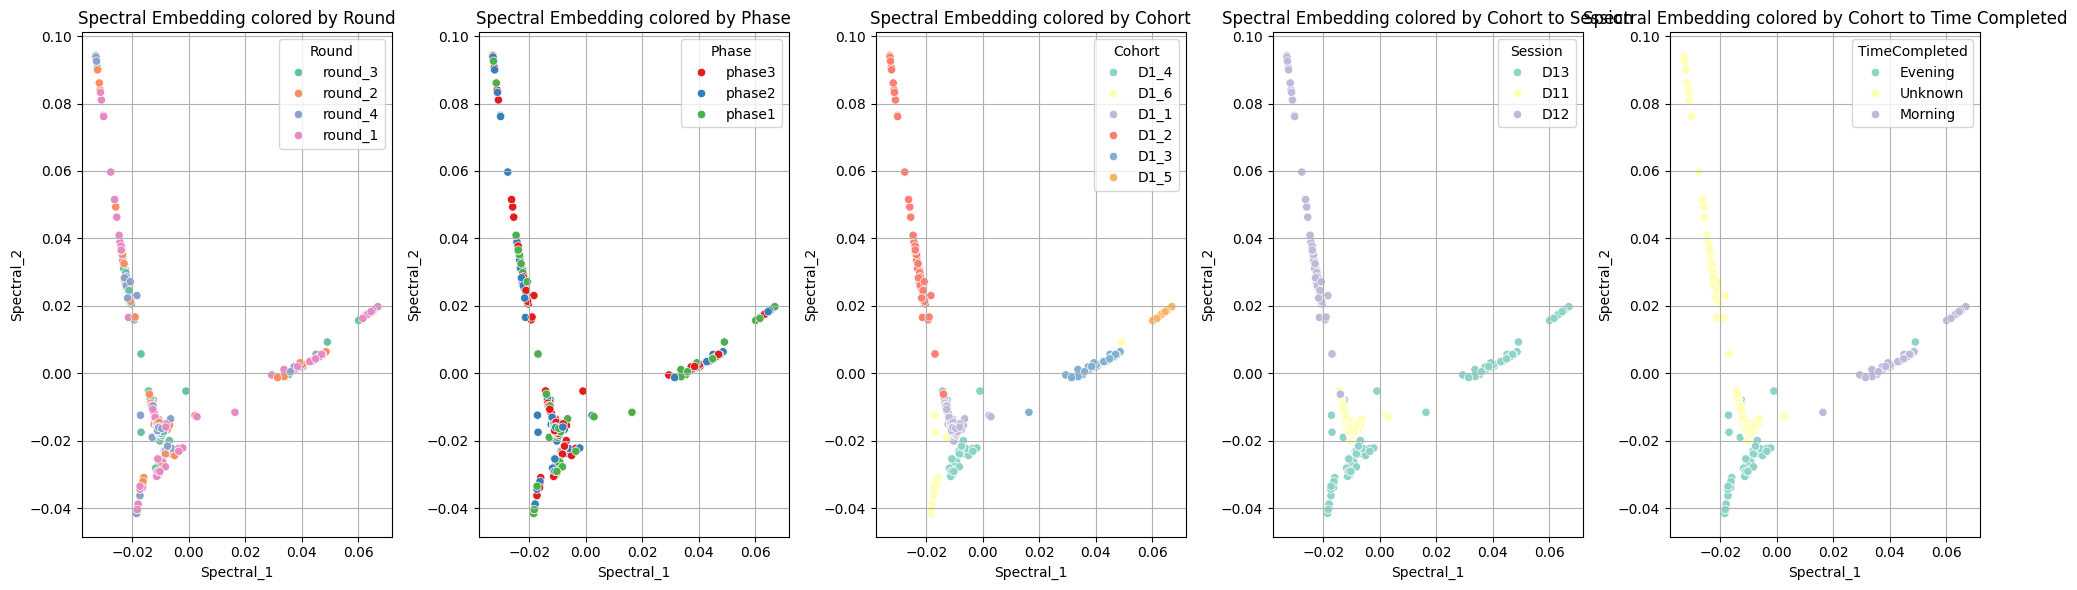

In [151]:
# Apply Spectral Embedding
embedding = SpectralEmbedding(n_components=2, n_neighbors=5, random_state=42)
spectral_components = embedding.fit_transform(data_scaled)

# Create a DataFrame
spectral_df = pd.DataFrame(spectral_components, columns=["Spectral_1", "Spectral_2"])
spectral_df["Round"] = rounds.values
spectral_df["Phase"] = phases.values
spectral_df["Cohort"] = cohorts.values
spectral_df["Session"] = cohorts_session.values
spectral_df["TimeCompleted"] = cohortts_timeCompleted.values

# Plot the results
fig, axes = plt.subplots(1, 5, figsize=(20, 6))

sns.scatterplot(data=spectral_df, x="Spectral_1", y="Spectral_2", hue="Round", ax=axes[0], palette="Set2")
axes[0].set_title("Spectral Embedding colored by Round")
axes[0].grid(True)

sns.scatterplot(data=spectral_df, x="Spectral_1", y="Spectral_2", hue="Phase", ax=axes[1], palette="Set1")
axes[1].set_title("Spectral Embedding colored by Phase")
axes[1].grid(True)

sns.scatterplot(data=spectral_df, x="Spectral_1", y="Spectral_2", hue="Cohort", ax=axes[2], palette="Set3")
axes[2].set_title("Spectral Embedding colored by Cohort")
axes[2].grid(True)

sns.scatterplot(data=spectral_df, x="Spectral_1", y="Spectral_2", hue="Session", ax=axes[3], palette="Set3")
axes[3].set_title("Spectral Embedding colored by Cohort to Session")
axes[3].grid(True)

sns.scatterplot(data=spectral_df, x="Spectral_1", y="Spectral_2", hue="TimeCompleted", ax=axes[4], palette="Set3")
axes[4].set_title("Spectral Embedding colored by Cohort to Time Completed")
axes[4].grid(True)

plt.tight_layout()
plt.show()